In [89]:
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve
from scipy import stats
import seaborn as sns 

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

In [90]:
# 폰트 파일의 경로 지정
font_path = r'C:\Windows\Fonts\gulim.ttc'

In [91]:
# matplotlib 패키지에 한글 폰트 설정
myFont = fm.FontProperties(fname = font_path).get_name()
mpl.rc('font', family = myFont)

In [92]:
file_data = '../DATA/HousingData.csv'

In [93]:
houseDF = pd.read_csv(file_data)
houseDF.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


In [94]:
houseDF.shape

(506, 14)

In [95]:
houseDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     486 non-null    float64
 1   ZN       486 non-null    float64
 2   INDUS    486 non-null    float64
 3   CHAS     486 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      486 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    486 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [96]:
# 중복데이터 없음
houseDF.drop_duplicates().shape

(506, 14)

In [97]:
# 결측값 확인
houseDF.isna().sum()

CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64

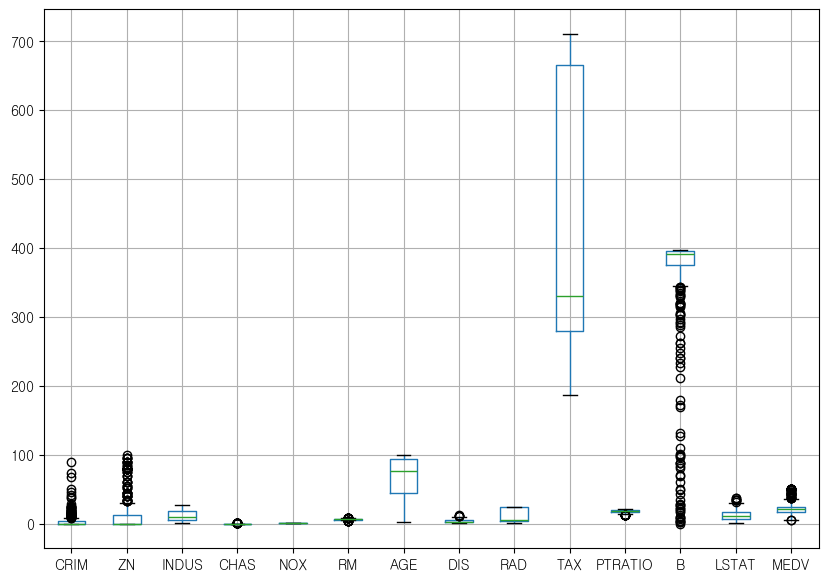

In [98]:
houseDF.boxplot(figsize = (10, 7))
plt.show()

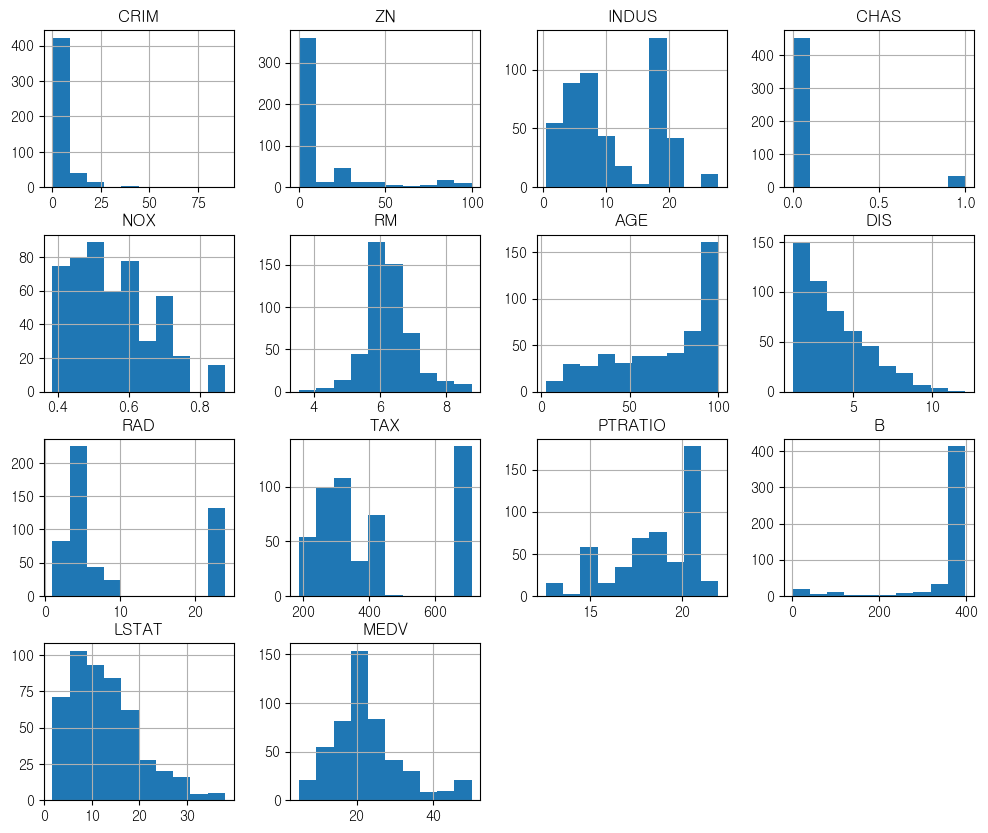

In [99]:
houseDF.hist(figsize = (12, 10))
plt.show()

In [100]:
# 사분위수 기반 이상치 탐지 함수
def find_outlier2(column_list, scale = 1.5, df = houseDF):
    for col in column_list:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        
        # 이상치로 판단할 기준이 되는 값
        lower = q1 - scale*iqr
        upper = q3 + scale*iqr
        mask = (df[col] < lower) | (df[col] > upper) 
        
        print(f'{col} 특성의 이상치 개수 : {df[col][mask].count()}개\n')

In [101]:
find_outlier2(houseDF.columns)

CRIM 특성의 이상치 개수 : 65개

ZN 특성의 이상치 개수 : 63개

INDUS 특성의 이상치 개수 : 0개

CHAS 특성의 이상치 개수 : 34개

NOX 특성의 이상치 개수 : 0개

RM 특성의 이상치 개수 : 30개

AGE 특성의 이상치 개수 : 0개

DIS 특성의 이상치 개수 : 5개

RAD 특성의 이상치 개수 : 0개

TAX 특성의 이상치 개수 : 0개

PTRATIO 특성의 이상치 개수 : 15개

B 특성의 이상치 개수 : 77개

LSTAT 특성의 이상치 개수 : 7개

MEDV 특성의 이상치 개수 : 40개



In [102]:
# 특성별 고유값 개수
houseDF.nunique()

CRIM       484
ZN          26
INDUS       76
CHAS         2
NOX         81
RM         446
AGE        348
DIS        412
RAD          9
TAX         66
PTRATIO     46
B          357
LSTAT      438
MEDV       229
dtype: int64

In [103]:
# 사분위수 기반 이상치 제거 함수
def delete_outlier(column_list, scale = 1.5, df = houseDF):
    del_index_list = []
    for column in column_list:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - scale*iqr
        upper = q3 + scale*iqr
        mask = (df[column] > upper) | (df[column] < lower)
        index_list = list(df[mask].index)
        del_index_list += index_list
    
    del_index_list = list(set(del_index_list))
    df = df.drop(del_index_list)
    df.reset_index(drop = True, inplace = True)
    
    return df

In [104]:
# 사분위수 기반 DIS, LSTAT 피처 이상치인 데이터 삭제
houseDF = delete_outlier(['DIS', 'LSTAT'])
houseDF.shape

(494, 14)

In [105]:
houseDF.MEDV.describe()

count    494.000000
mean      22.686842
std        9.196607
min        5.000000
25%       17.125000
50%       21.400000
75%       25.000000
max       50.000000
Name: MEDV, dtype: float64

In [106]:
houseDF.MEDV.value_counts()

MEDV
50.0    16
25.0     8
22.0     7
21.7     7
23.1     7
        ..
46.7     1
37.6     1
44.8     1
26.7     1
8.1      1
Name: count, Length: 227, dtype: int64

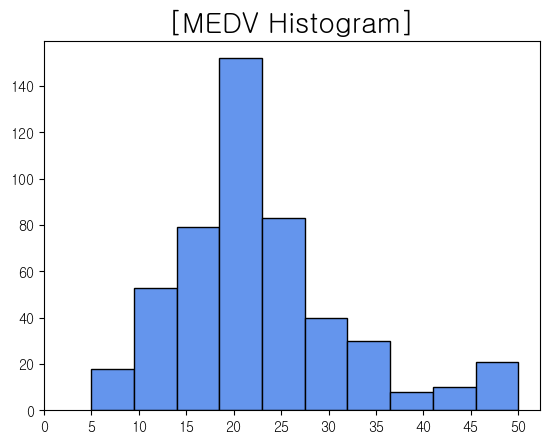

In [107]:
plt.hist(houseDF.MEDV, bins = 10, edgecolor = 'black', color = 'cornflowerblue')
plt.xticks(np.linspace(0, 50, 11))
plt.title('[MEDV Histogram]', size = 20)
plt.show()

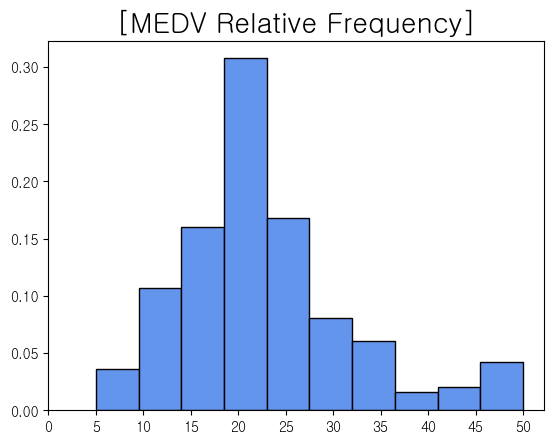

In [108]:
weights = np.ones_like(houseDF.MEDV) / houseDF.shape[0]
plt.hist(houseDF.MEDV, bins = 10, edgecolor = 'black', weights = weights, color = 'cornflowerblue')
plt.xticks(np.linspace(0, 50, 11))
plt.title('[MEDV Relative Frequency]', size = 20)
plt.show()

In [109]:
# 결측치가 있는 특성 목록
houseDF.columns[houseDF.isna().sum() != 0]

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'AGE', 'LSTAT'], dtype='object')

In [110]:
# 범주형 피처 CHAS, RAD 제외한 상관계수
houseDF[houseDF.columns.difference(['CHAS', 'RAD'])].corr()

,AGE,B,CRIM,DIS,INDUS,LSTAT,MEDV,NOX,PTRATIO,RM,TAX,ZN
AGE,1.000000,-0.269429,0.342177,-0.744567,0.626356,0.603386,-0.390315,0.725537,0.266759,-0.231141,0.502030,-0.551797
B,-0.269429,1.000000,-0.359967,0.296866,-0.359289,-0.355889,0.328897,-0.378704,-0.173699,0.108561,-0.436480,0.168583
CRIM,0.342177,-0.359967,1.000000,-0.373479,0.392638,0.405567,-0.375983,0.406808,0.276792,-0.176304,0.570553,-0.183236
DIS,-0.744567,0.296866,-0.373479,1.000000,-0.709704,-0.482006,0.252419,-0.777217,-0.254269,0.199407,-0.544121,0.630108
INDUS,0.626356,-0.359289,0.392638,-0.709704,1.000000,0.584998,-0.478794,0.758354,0.395349,-0.381756,0.730882,-0.519595
LSTAT,0.603386,-0.355889,0.405567,-0.482006,0.584998,1.000000,-0.750055,0.580992,0.373266,-0.588130,0.519581,-0.417879
MEDV,-0.390315,0.328897,-0.375983,0.252419,-0.478794,-0.750055,1.000000,-0.421033,-0.502106,0.693343,-0.457248,0.380179
NOX,0.725537,-0.378704,0.406808,-0.777217,0.758354,0.580992,-0.421033,1.000000,0.188201,-0.293215,0.664170,-0.503197
PTRATIO,0.266759,-0.173699,0.276792,-0.254269,0.395349,0.373266,-0.502106,0.188201,1.000000,-0.341230,0.459275,-0.430085
RM,-0.231141,0.108561,-0.176304,0.199407,-0.381756,-0.588130,0.693343,-0.293215,-0.341230,1.000000,-0.266986,0.330771


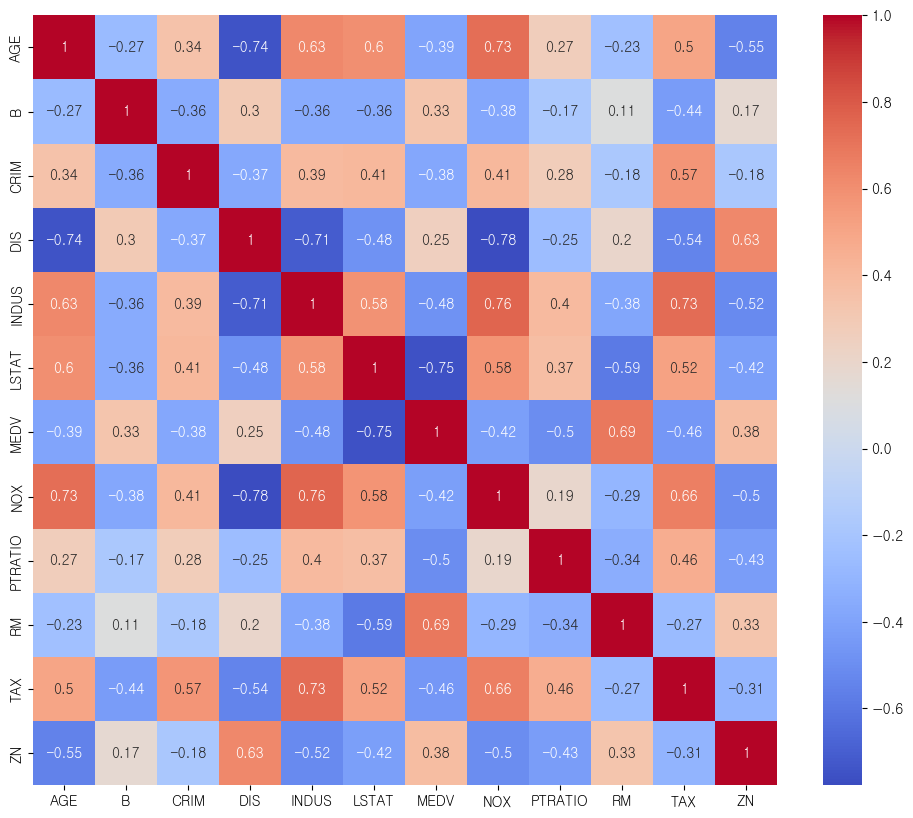

In [111]:
# 상관행렬 시각화, 범주형 데이터 CHAS, RAD 피처 제외
# cmap = sns.light_palette("darkgray", as_cmap = True)  
plt.figure(figsize = (12, 10))
sns.heatmap(houseDF[houseDF.columns.difference(['CHAS', 'RAD'])].corr(), annot = True, cmap = 'coolwarm')
plt.show()

In [112]:
def print_feature(nrows, ncols, target, features, corrs, df = houseDF):
    for idx in range(len(features)):
        plt.subplot(nrows, ncols, idx + 1)
        plt.scatter(df[target], df[features[idx]], label = f'corr : {corrs[idx]:.2}', color = 'cornflowerblue')
        plt.xlabel(target)
        plt.ylabel(features[idx])
        plt.legend()
    plt.tight_layout()
    plt.show()

In [113]:
houseDF.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

In [114]:
numerical_col = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE',
                 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

In [115]:
corrs = houseDF[numerical_col].corr()

C:\Users\user\AppData\Local\Temp\ipykernel_17464\3322633811.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(df[target], df[features[idx]], label = f'corr : {corrs[idx]:.2}', color = 'cornflowerblue')


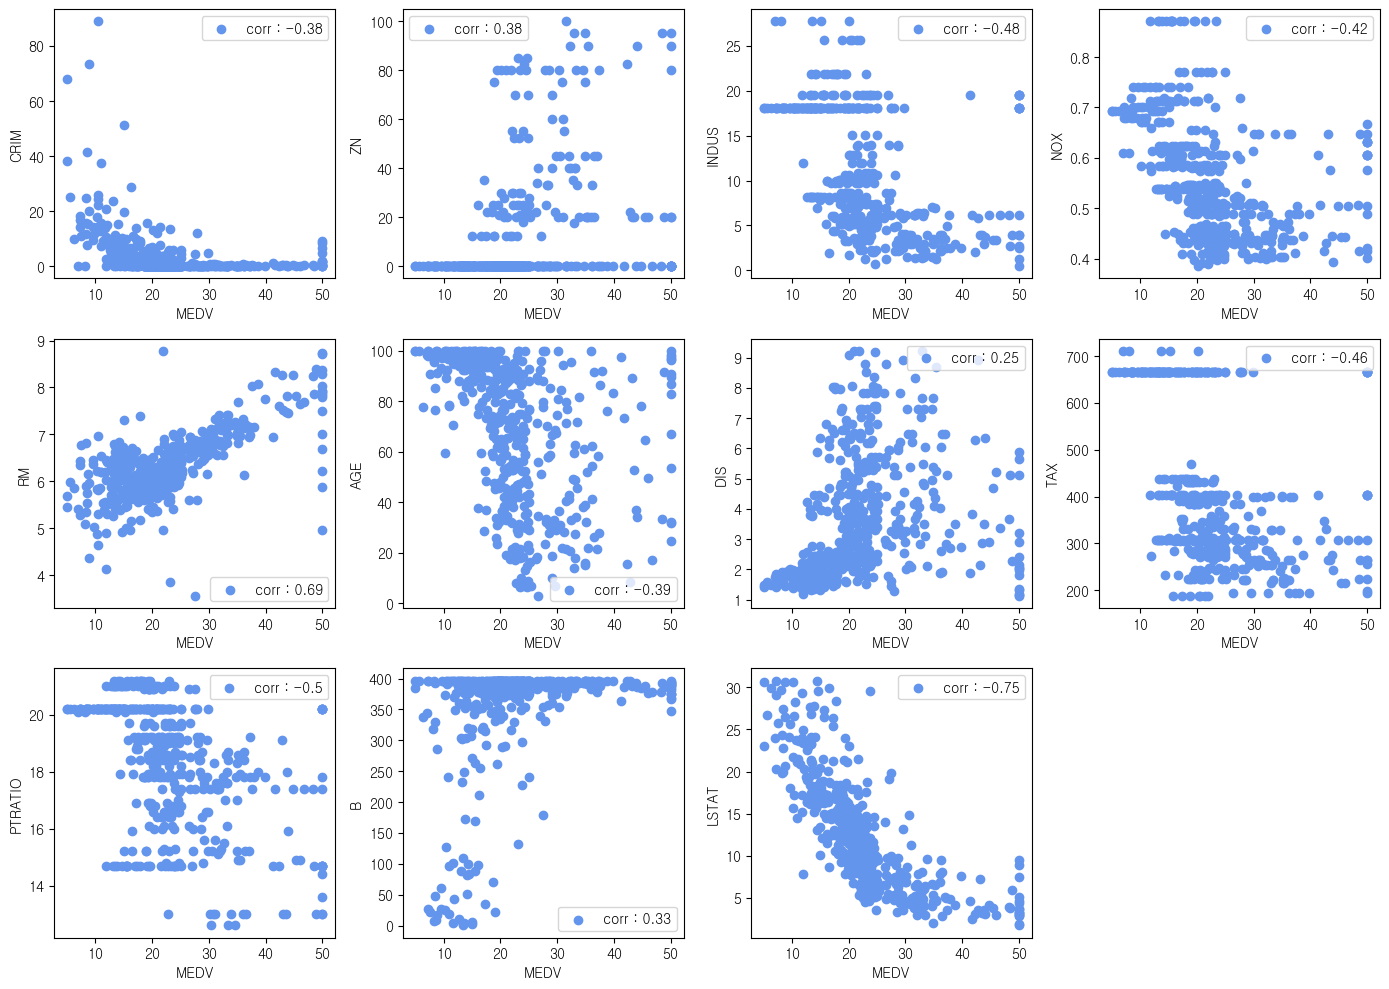

In [116]:
corrs = houseDF[numerical_col].corr()['MEDV']
plt.figure(figsize = (14, 10))
print_feature(3, 4, 'MEDV', numerical_col[:-1], corrs[:-1], houseDF[numerical_col])

In [117]:
# 이진 범주형 데이터 특성'CHAS'와 수치형 데이터 특성 MEDV의 상관계수
houseDF.dropna(subset = ['CHAS']).shape
stats.pointbiserialr(houseDF.dropna(subset = ['CHAS']).MEDV, houseDF.dropna(subset = ['CHAS']).CHAS).statistic

0.1789511155881533

In [118]:
corrs = houseDF.corr()['MEDV'][:-1]
corrs.abs() > 0.4

CRIM       False
ZN         False
INDUS       True
CHAS       False
NOX         True
RM          True
AGE        False
DIS        False
RAD        False
TAX         True
PTRATIO     True
B          False
LSTAT       True
Name: MEDV, dtype: bool

In [119]:
houseDF[houseDF.columns[:-1]]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,NaN
490,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08
491,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64
492,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48


In [120]:
houseDF.nunique()

CRIM       472
ZN          26
INDUS       73
CHAS         2
NOX         81
RM         438
AGE        345
DIS        402
RAD          9
TAX         63
PTRATIO     45
B          349
LSTAT      429
MEDV       227
dtype: int64

In [121]:
houseDF.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


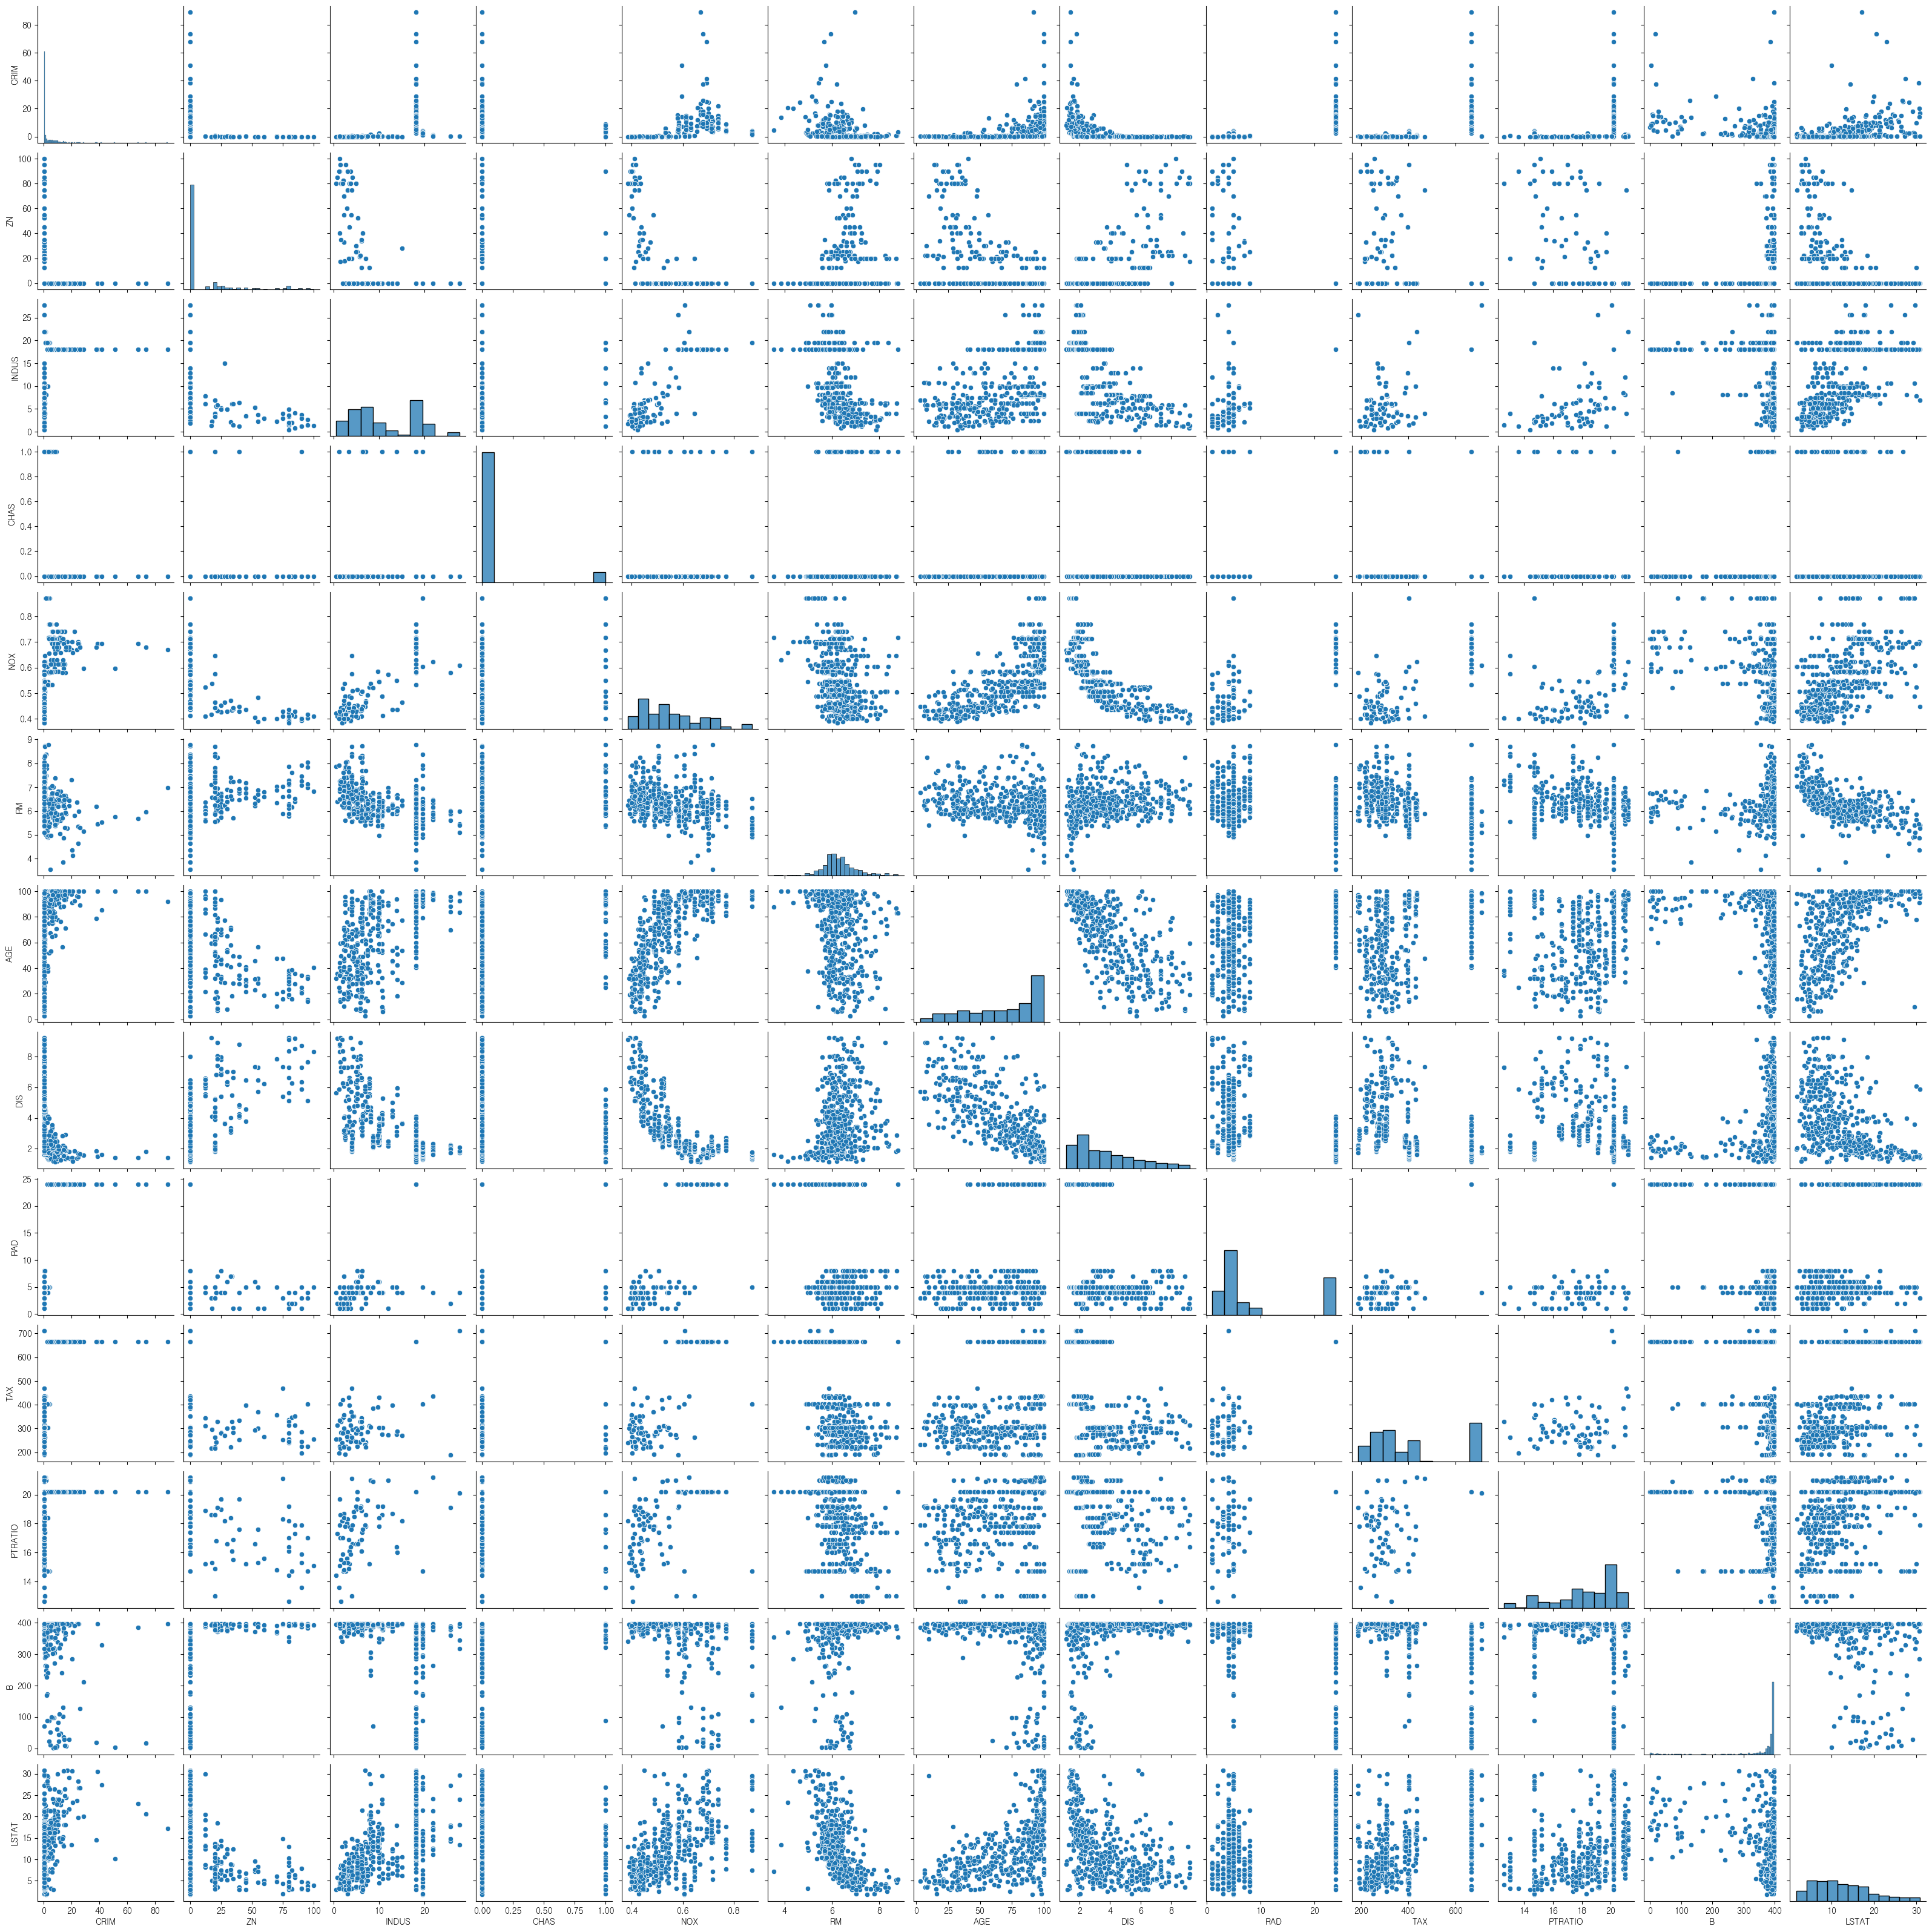

In [122]:
# 변수끼리 산점도를 시각화
sns.pairplot(houseDF[houseDF.columns[:-1]])
plt.show()

In [123]:
corrs[corrs.abs() > 0.4]

INDUS     -0.478794
NOX       -0.421033
RM         0.693343
TAX       -0.457248
PTRATIO   -0.502106
LSTAT     -0.750055
Name: MEDV, dtype: float64

In [124]:
# MEDV와 상관계수가 0.4 보다 큰 특성이름 추출
corrs[corrs.abs() > 0.4].index

Index(['INDUS', 'NOX', 'RM', 'TAX', 'PTRATIO', 'LSTAT'], dtype='object')

In [125]:
# MEDV와 상관계수가 0.4 보다 큰 특성들의 상관계수를 조사하여 다중공선성 체크
feature = corrs[corrs.abs() > 0.4].index
houseDF[feature].corr()


,INDUS,NOX,RM,TAX,PTRATIO,LSTAT
INDUS,1.000000,0.758354,-0.381756,0.730882,0.395349,0.584998
NOX,0.758354,1.000000,-0.293215,0.664170,0.188201,0.580992
RM,-0.381756,-0.293215,1.000000,-0.266986,-0.341230,-0.588130
TAX,0.730882,0.664170,-0.266986,1.000000,0.459275,0.519581
PTRATIO,0.395349,0.188201,-0.341230,0.459275,1.000000,0.373266
LSTAT,0.584998,0.580992,-0.588130,0.519581,0.373266,1.000000


In [126]:
houseDF[feature].corr() >= 0.5

,INDUS,NOX,RM,TAX,PTRATIO,LSTAT
INDUS,True,True,False,True,False,True
NOX,True,True,False,True,False,True
RM,False,False,True,False,False,False
TAX,True,True,False,True,False,True
PTRATIO,False,False,False,False,True,False
LSTAT,True,True,False,True,False,True


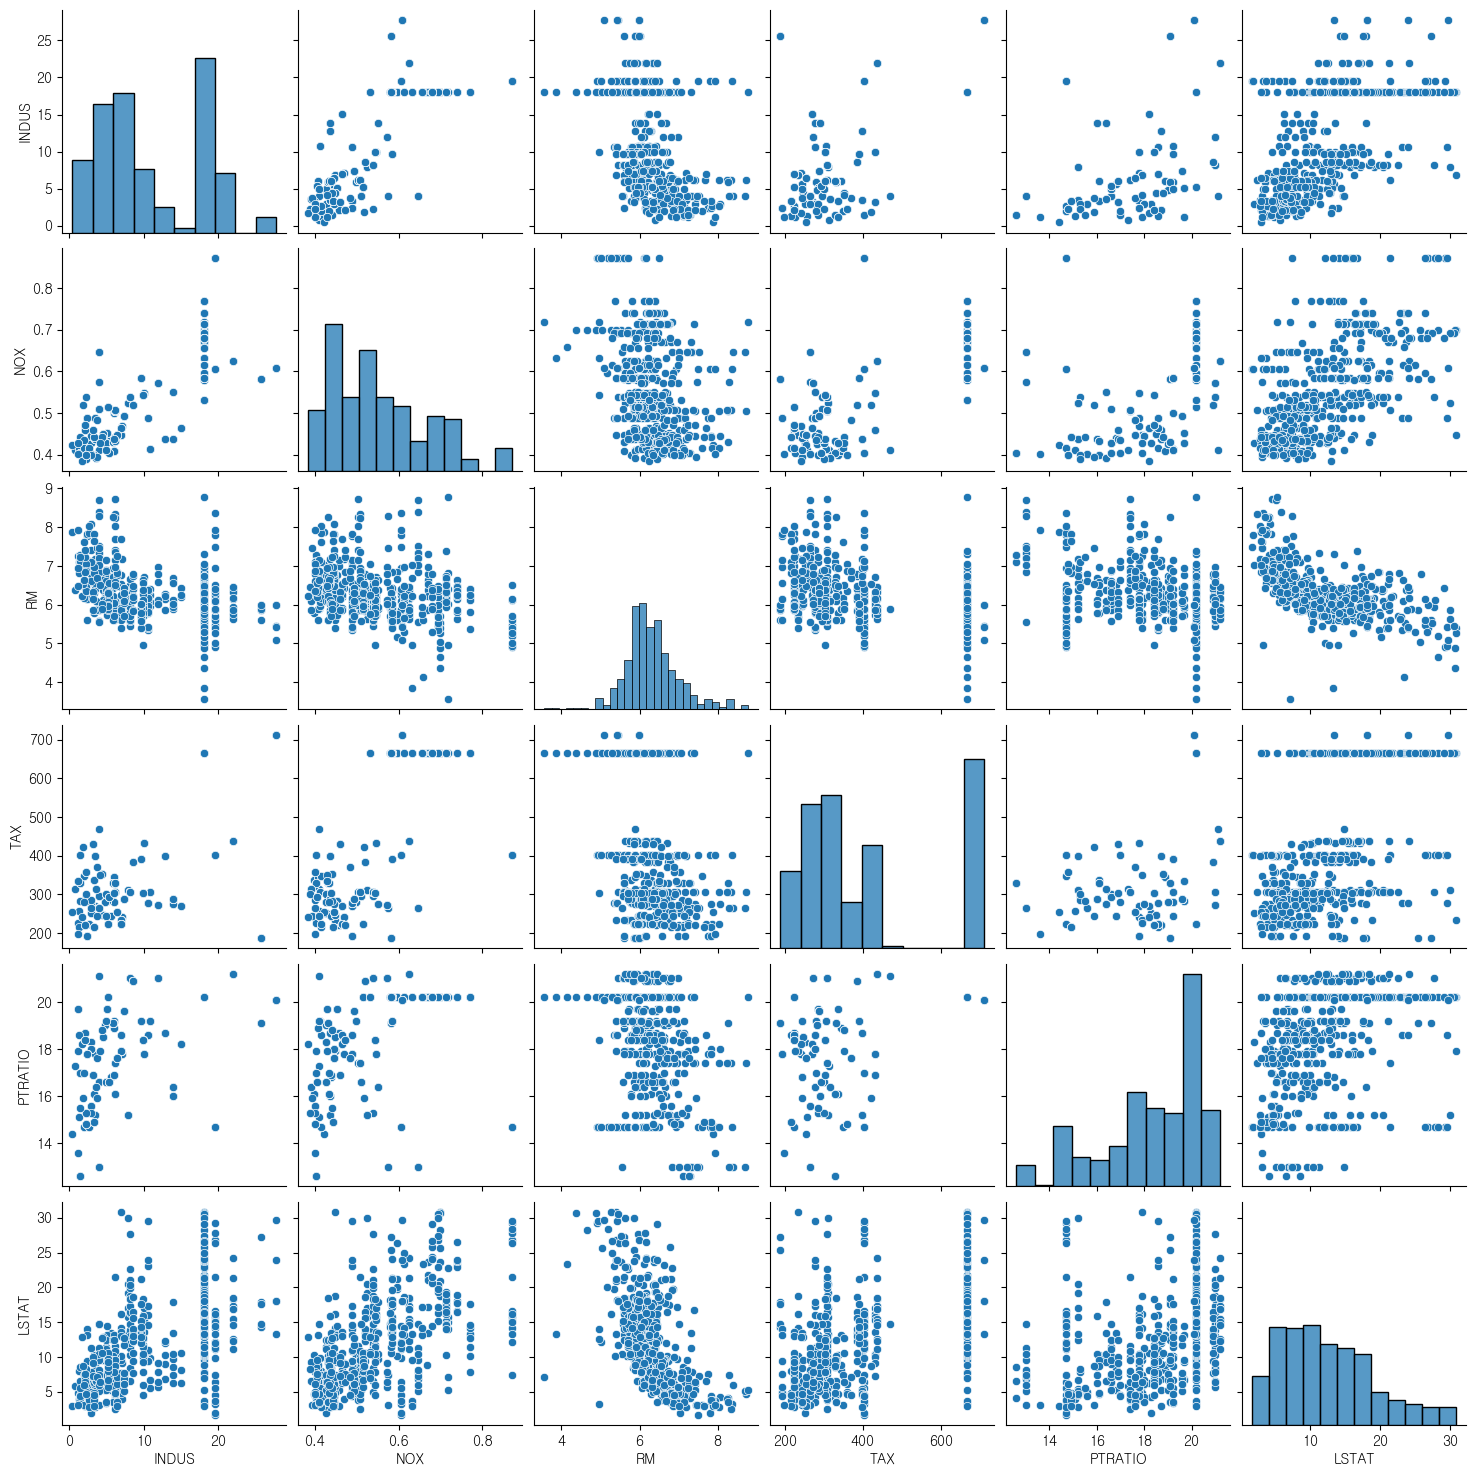

In [127]:
# 변수끼리 산점도를 시각화
sns.pairplot(houseDF[feature])
plt.show()

In [128]:
feature = corrs[corrs.abs() > 0.4].index
houseDF[feature]

,INDUS,NOX,RM,TAX,PTRATIO,LSTAT
0,2.31,0.538,6.575,296,15.3,4.98
1,7.07,0.469,6.421,242,17.8,9.14
2,7.07,0.469,7.185,242,17.8,4.03
3,2.18,0.458,6.998,222,18.7,2.94
4,2.18,0.458,7.147,222,18.7,NaN
...,...,...,...,...,...,...
489,11.93,0.573,6.593,273,21.0,NaN
490,11.93,0.573,6.120,273,21.0,9.08
491,11.93,0.573,6.976,273,21.0,5.64
492,11.93,0.573,6.794,273,21.0,6.48


In [129]:
featureDF = houseDF[feature]
targetSR = houseDF['MEDV']

print(f'featureDF => {featureDF.shape}\n\ntargetSR => {targetSR.shape}')

featureDF => (494, 6)

targetSR => (494,)


In [130]:
# 결측치가 하나라도 있는 행은 제거한 나머지 추출
featureDF = featureDF.dropna()

# 타겟시리즈에 위 피처데이터의 인덱스 정보를 넣어서 추출
targetSR = targetSR[featureDF.index]

# 인덱스 재조정 => 0부터 순차적으로
featureDF.reset_index(drop = True, inplace = True)
targetSR.reset_index(drop = True, inplace = True)

In [131]:
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetSR, test_size = 0.2, random_state = 6)

In [132]:
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

In [133]:
std_scaler.fit(X_train)
scaled_X_train = std_scaler.transform(X_train)
scaled_X_test = std_scaler.transform(X_test)

In [134]:
# 성능 안 좋다.
# mm_scaler.fit(X_train)
# scaled_X_train = mm_scaler.transform(X_train)
# scaled_X_test = mm_scaler.transform(X_test)

In [135]:
lr_model = LinearRegression()
lr_model.fit(scaled_X_train, y_train)
lr_model.score(scaled_X_test, y_test)

0.5916642672783203

In [136]:
# 모델 파라미터
print(lr_model.coef_, lr_model.intercept_)

[ 0.97534713 -0.29628682  3.8715304  -0.67561956 -1.62560784 -4.10136487] 22.65399449035813


In [137]:
y_pre1 = lr_model.predict(scaled_X_test)

In [138]:
print(r2_score(y_pre1, y_test), mean_absolute_error(y_pre1, y_test), mean_squared_error(y_pre1, y_test))

0.44733750174401565 3.9458299694993153 33.86430648236263


- 릿지 회귀

In [139]:
ridge_model = Ridge(max_iter = 10000, alpha = 60)
ridge_model.fit(scaled_X_train, y_train)
ridge_model.score(scaled_X_test, y_test)

0.6111341113632671

In [140]:
# 모델 파라미터
print(ridge_model.n_iter_, ridge_model.coef_, ridge_model.intercept_)

None [ 0.3234587  -0.3389791   3.47561578 -0.59501804 -1.5812325  -3.42646051] 22.65399449035813


In [141]:
y_pre2 = ridge_model.predict(scaled_X_test)

In [142]:
print(r2_score(y_pre2, y_test), mean_absolute_error(y_pre2, y_test), mean_squared_error(y_pre2, y_test))

0.3782866729413892 3.814003975335441 32.24962347908539


- 라쏘 회귀

In [143]:
lasso_model = Lasso(max_iter = 10000, alpha = 0.1)
lasso_model.fit(scaled_X_train, y_train)
lasso_model.score(scaled_X_test, y_test)

0.5983446205044766

In [144]:
# 모델 파라미터
print(lasso_model.n_iter_, lasso_model.coef_, lasso_model.intercept_)

21 [ 0.38358014 -0.          3.77200304 -0.45262887 -1.51397832 -4.05698012] 22.65399449035813


In [145]:
y_pre3 = lasso_model.predict(scaled_X_test)

In [146]:
print(r2_score(y_pre3, y_test), mean_absolute_error(y_pre3, y_test), mean_squared_error(y_pre3, y_test))

0.4394739994697835 3.8997463526115483 33.3102880339816


#### 피처 추가

In [147]:
poly = PolynomialFeatures(degree = 2)
poly.fit(featureDF)
poly_data = poly.transform(featureDF)

In [148]:
poly_data.shape

(454, 28)

In [149]:
poly_feature_names = poly.get_feature_names_out(featureDF.columns)
poly_feature_names

array(['1', 'INDUS', 'NOX', 'RM', 'TAX', 'PTRATIO', 'LSTAT', 'INDUS^2',
       'INDUS NOX', 'INDUS RM', 'INDUS TAX', 'INDUS PTRATIO',
       'INDUS LSTAT', 'NOX^2', 'NOX RM', 'NOX TAX', 'NOX PTRATIO',
       'NOX LSTAT', 'RM^2', 'RM TAX', 'RM PTRATIO', 'RM LSTAT', 'TAX^2',
       'TAX PTRATIO', 'TAX LSTAT', 'PTRATIO^2', 'PTRATIO LSTAT',
       'LSTAT^2'], dtype=object)

In [150]:
featureDF.columns

Index(['INDUS', 'NOX', 'RM', 'TAX', 'PTRATIO', 'LSTAT'], dtype='object')

In [151]:
new_featureDF = pd.DataFrame(poly_data, columns = poly_feature_names)
new_featureDF.head()

,1,INDUS,NOX,RM,TAX,PTRATIO,LSTAT,INDUS^2,INDUS NOX,INDUS RM,...,RM^2,RM TAX,RM PTRATIO,RM LSTAT,TAX^2,TAX PTRATIO,TAX LSTAT,PTRATIO^2,PTRATIO LSTAT,LSTAT^2
0,1.0,2.31,0.538,6.575,296.0,15.3,4.98,5.3361,1.24278,15.18825,...,43.230625,1946.200,100.5975,32.74350,87616.0,4528.8,1474.08,234.09,76.194,24.8004
1,1.0,7.07,0.469,6.421,242.0,17.8,9.14,49.9849,3.31583,45.39647,...,41.229241,1553.882,114.2938,58.68794,58564.0,4307.6,2211.88,316.84,162.692,83.5396
2,1.0,7.07,0.469,7.185,242.0,17.8,4.03,49.9849,3.31583,50.79795,...,51.624225,1738.770,127.8930,28.95555,58564.0,4307.6,975.26,316.84,71.734,16.2409
3,1.0,2.18,0.458,6.998,222.0,18.7,2.94,4.7524,0.99844,15.25564,...,48.972004,1553.556,130.8626,20.57412,49284.0,4151.4,652.68,349.69,54.978,8.6436
4,1.0,2.18,0.458,6.430,222.0,18.7,5.21,4.7524,0.99844,14.01740,...,41.344900,1427.460,120.2410,33.50030,49284.0,4151.4,1156.62,349.69,97.427,27.1441


In [152]:
# scaler에 따른 점수 반환 함수
def score_return(feature, target, my_scaler, degree, my_model = LinearRegression(), threshold = 0.4, test_size = 0.2, random_state = 42, df = houseDF):
    corrs = df.corr()['MEDV'][:-1]
    feature = corrs[corrs.abs() > threshold].index
    featureDF = df[feature]
    targetSR = df[target]
    # 결측치가 하나라도 있는 행은 제거한 나머지 추출
    featureDF = featureDF.dropna()

    # 타겟시리즈에 위 피처데이터의 인덱스 정보를 넣어서 추출
    targetSR = targetSR[featureDF.index]

    # 인덱스 재조정 => 0부터 순차적으로
    featureDF.reset_index(drop = True, inplace = True)
    targetSR.reset_index(drop = True, inplace = True)
    
    # 피처 추가
    poly = PolynomialFeatures(include_bias = False, degree = degree)
    poly.fit(featureDF)  # fit에 넣을 데이터는 2차원이어야 한다.
    poly_data = poly.transform(featureDF)
    poly_feature_names = poly.get_feature_names_out(featureDF.columns)
    new_df = pd.DataFrame(poly_data, columns = poly_feature_names)
    new_df = pd.concat([new_df, targetSR], axis = 1)
    featureDF = new_df[new_df.columns[:-1]]
    targetDF = new_df[target] 
    X_train, X_test, y_train, y_test = train_test_split(featureDF, targetDF, test_size = test_size, random_state = random_state)
    my_scaler.fit(X_train)
    scaled_X_train = my_scaler.transform(X_train)
    scaled_X_test = my_scaler.transform(X_test)

    my_model.fit(scaled_X_train, y_train)
    return round(my_model.score(scaled_X_train, y_train), 2), round(my_model.score(scaled_X_test, y_test), 2)

In [153]:
# LinearRegression
score_return(houseDF.columns[:-1], 'MEDV', StandardScaler(), 2)

(0.87, 0.77)

In [154]:
# LinearRegression
score_return(houseDF.columns[:-1], 'MEDV', StandardScaler(), 2, threshold = 0.4)

(0.87, 0.77)

In [155]:
# Ridge
score_return(houseDF.columns[:-1], 'MEDV', StandardScaler(), 2, Ridge(), threshold = 0.3)

(0.88, 0.77)

In [156]:
# Ridge
score_return(houseDF.columns[:-1], 'MEDV', StandardScaler(), 2, Ridge(), threshold = 0.4)

(0.85, 0.8)

In [157]:
# Ridge
score_return(houseDF.columns[:-1], 'MEDV', StandardScaler(), 2, Ridge(), threshold = 0.5)

(0.8, 0.71)

In [158]:
# Ridge
score_return(houseDF.columns[:-1], 'MEDV', StandardScaler(), 2, Ridge(), threshold = 0.6)

(0.76, 0.71)

In [159]:
# Lasso
score_return(houseDF.columns[:-1], 'MEDV', StandardScaler(), 2, Lasso())

(0.72, 0.72)

In [160]:
# Lasso
score_return(houseDF.columns[:-1], 'MEDV', StandardScaler(), 2, Lasso(), threshold = 0.6)

(0.7, 0.66)

In [161]:
# ElasticNet
score_return(houseDF.columns[:-1], 'MEDV', StandardScaler(), 9, ElasticNet())

(0.76, 0.78)

In [162]:
# 릿지 최적의 규제 강도 설정 값 찾기
alphas = [0.1, 1., 5., 10., 15., 20., 25., 30.,]

ridge_score = [[], []]
for a in alphas:
    result = score_return(houseDF.columns[:-1], 'MEDV', StandardScaler(), 2, Ridge(alpha = a))

    ridge_score[0].append(result[0])
    ridge_score[1].append(result[1])

In [163]:
# 테스트 점수가 가장 높은 alpha
best_alpha = alphas[ridge_score[1].index(max(ridge_score[1]))]
max(ridge_score[1])

0.8

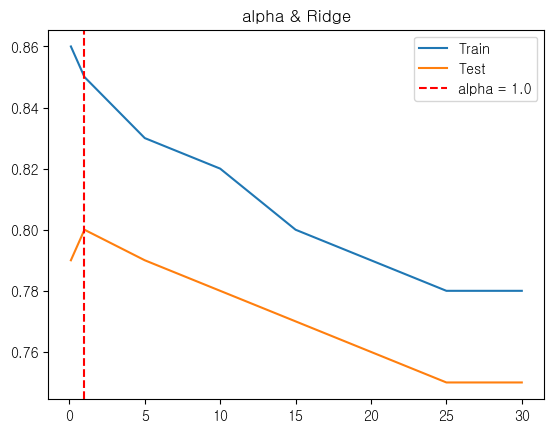

In [164]:
# 학습 및 테스트 점수 시각화
plt.plot(alphas, ridge_score[0], label = 'Train')
plt.plot(alphas, ridge_score[1], label = 'Test')
plt.axvline(best_alpha, linestyle = '--', color = 'red', label = f'alpha = {best_alpha}')
plt.legend()
plt.title('alpha & Ridge')
plt.show()

In [165]:
# 라쏘 최적의 규제 강도 설정 값 찾기
alphas = [0.1, 1., 5., 10., 15., 20., 25., 30.,]

lasso_score = [[], []]
for a in alphas:
    result = score_return(houseDF.columns[:-1], 'MEDV', StandardScaler(), 2, Lasso(alpha = a))

    lasso_score[0].append(result[0])
    lasso_score[1].append(result[1])

In [166]:
# 테스트 점수가 가장 높은 alpha
best_alpha = alphas[lasso_score[1].index(max(lasso_score[1]))]
max(lasso_score[1])

0.77

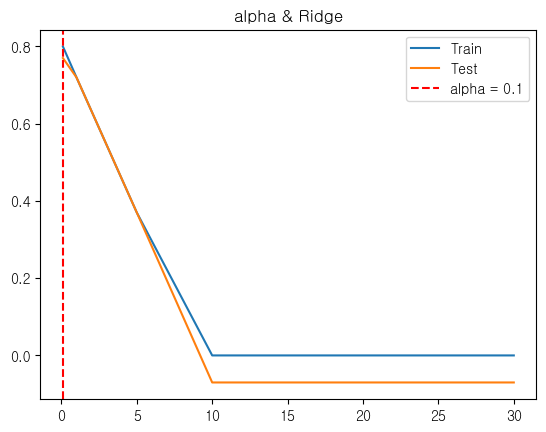

In [167]:
# 학습 및 테스트 점수 시각화
plt.plot(alphas, lasso_score[0], label = 'Train')
plt.plot(alphas, lasso_score[1], label = 'Test')
plt.axvline(best_alpha, linestyle = '--', color = 'red', label = f'alpha = {best_alpha}')
plt.legend()
plt.title('alpha & Ridge')
plt.show()

In [168]:
# 엘라스틱넷 최적의 규제 강도 설정 값 찾기
alphas = [0.1, 1., 5., 10., 15., 20., 25., 30.,]

ela_score = [[], []]
for a in alphas:
    result = score_return(houseDF.columns[:-1], 'MEDV', StandardScaler(), 2, ElasticNet(alpha = a, l1_ratio = 0.3))

    ela_score[0].append(result[0])
    ela_score[1].append(result[1])

In [169]:
# 테스트 점수가 가장 높은 alpha
best_alpha = alphas[ela_score[1].index(max(ela_score[1]))]
max(ela_score[1])

0.75

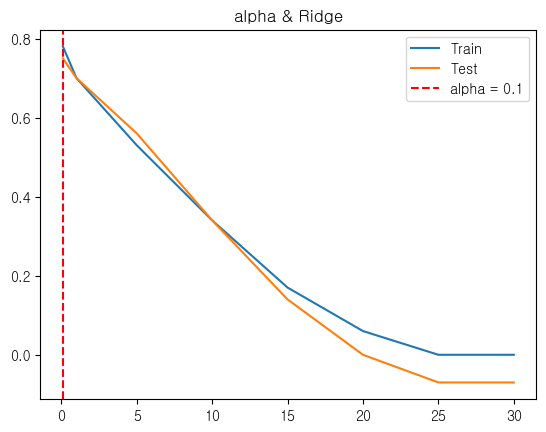

In [170]:
# 학습 및 테스트 점수 시각화
plt.plot(alphas, ela_score[0], label = 'Train')
plt.plot(alphas, ela_score[1], label = 'Test')
plt.axvline(best_alpha, linestyle = '--', color = 'red', label = f'alpha = {best_alpha}')
plt.legend()
plt.title('alpha & Ridge')
plt.show()

#### 다중 공선성을 고려하여 특성 3개 데이터만 추출

In [171]:
featureDF = houseDF[['RM', 'PTRATIO', 'LSTAT']].dropna()
#targetSR = houseDF[featureDF.index]['MEDV']
targetSR = houseDF.iloc[featureDF.index]['MEDV']


In [172]:
# 인덱스 재조정 => 0부터 순차적으로
featureDF.reset_index(drop = True, inplace = True)
targetSR.reset_index(drop = True, inplace = True)

In [173]:
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetSR, test_size = 0.2, random_state = 6)

In [174]:
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

In [175]:
std_scaler.fit(X_train)
scaled_X_train = std_scaler.transform(X_train)
scaled_X_test = std_scaler.transform(X_test)

In [176]:
lr_model = LinearRegression()
lr_model.fit(scaled_X_train, y_train)
lr_model.score(scaled_X_test, y_test)

0.6722315997622081

In [177]:
# 모델 파라미터
print(lr_model.coef_, lr_model.intercept_)

[ 2.71819979 -2.18665406 -4.12499766] 22.281794195250658


In [178]:
y_pre1 = lr_model.predict(scaled_X_test)

In [179]:
print(r2_score(y_pre1, y_test), mean_absolute_error(y_pre1, y_test), mean_squared_error(y_pre1, y_test))

0.33970319650100445 4.201014332532098 37.762343025887404


In [180]:
ridge_model = Ridge(alpha = 100)
ridge_model.fit(scaled_X_train, y_train)
ridge_model.score(scaled_X_test, y_test)

0.6393037539321751

In [181]:
# 모델 파라미터
print(ridge_model.coef_, ridge_model.intercept_)

[ 2.53170471 -2.00360529 -3.40579014] 22.281794195250658


In [182]:
y_pre2 = ridge_model.predict(scaled_X_test)

In [183]:
print(r2_score(y_pre2, y_test), mean_absolute_error(y_pre2, y_test), mean_squared_error(y_pre2, y_test))

0.05021499665080076 4.247775674496958 41.55597477450975


In [184]:
lasso_model = Lasso(alpha = 0.1)
lasso_model.fit(scaled_X_train, y_train)
lasso_model.score(scaled_X_test, y_test)

0.6692101912320567

In [185]:
# 모델 파라미터
print(lasso_model.coef_, lasso_model.intercept_)

[ 2.66705574 -2.12230172 -4.07971085] 22.281794195250658


In [186]:
y_pre3 = ridge_model.predict(scaled_X_test)

In [187]:
print(r2_score(y_pre3, y_test), mean_absolute_error(y_pre3, y_test), mean_squared_error(y_pre3, y_test))

0.05021499665080076 4.247775674496958 41.55597477450975


In [188]:
# scaler에 따른 점수 반환 함수
def score_return(feature, target, my_scaler, degree, my_model = LinearRegression(), test_size = 0.2, random_state = 42, df = houseDF):
    featureDF = df[feature]
    targetSR = df[target]
    # 결측치가 하나라도 있는 행은 제거한 나머지 추출
    featureDF = featureDF.dropna()

    # 타겟시리즈에 위 피처데이터의 인덱스 정보를 넣어서 추출
    targetSR = targetSR[featureDF.index]

    # 인덱스 재조정 => 0부터 순차적으로
    featureDF.reset_index(drop = True, inplace = True)
    targetSR.reset_index(drop = True, inplace = True)
    
    # 피처 추가
    poly = PolynomialFeatures(include_bias = False, degree = degree)
    poly.fit(featureDF)  # fit에 넣을 데이터는 2차원이어야 한다.
    poly_data = poly.transform(featureDF)
    poly_feature_names = poly.get_feature_names_out(featureDF.columns)
    new_df = pd.DataFrame(poly_data, columns = poly_feature_names)
    new_df = pd.concat([new_df, targetSR], axis = 1)
    featureDF = new_df[new_df.columns[:-1]]
    targetDF = new_df[target] 
    X_train, X_test, y_train, y_test = train_test_split(featureDF, targetDF, test_size = test_size, random_state = random_state)
    my_scaler.fit(X_train)
    scaled_X_train = my_scaler.transform(X_train)
    scaled_X_test = my_scaler.transform(X_test)

    my_model.fit(scaled_X_train, y_train)
    return round(my_model.score(scaled_X_train, y_train), 2), round(my_model.score(scaled_X_test, y_test), 2)

In [189]:
# LinearRegression
score_return(['RM', 'PTRATIO', 'LSTAT'], 'MEDV', StandardScaler(), 2)

(0.81, 0.71)

In [190]:
score_return(['RM', 'PTRATIO', 'LSTAT'], 'MEDV', StandardScaler(), 2, Ridge())

(0.8, 0.71)

In [191]:
score_return(['RM', 'PTRATIO', 'LSTAT'], 'MEDV', StandardScaler(), 2, Lasso())

(0.73, 0.68)